In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import NonlinearConstraint

In [2]:
import nlopt

In [3]:
from truss import Node, Bar, Truss

In [4]:
n00 = Node(0,0.25,freex=False, freey=False)
n01 = Node(1,0.25, freey=False)
n11 = Node(0.5,0.5)
n11.apply_load(0, -10**3)

In [5]:
xpos = np.linspace(-0.1, 1.1, num=4)
ypos = np.linspace(-0.1, 1.1, num=4)

In [6]:
xpos

array([-0.1,  0.3,  0.7,  1.1])

In [7]:
nodes = [n00, n01, n11]
for x in xpos:
    for y in ypos:
        #nodes.append(Node(x+np.random.uniform(-0.05, 0.05), y+np.random.uniform(-0.05, 0.05)))
        nodes.append(Node(x, y))

In [8]:
gridTruss = Truss.from_delaunay(nodes)
gridTruss.set_all_widths(0.01)

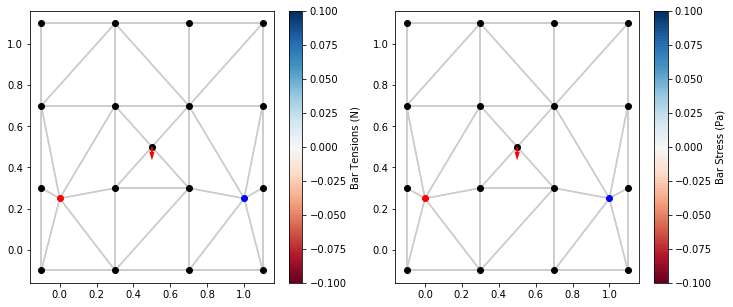

In [9]:
gridTruss.plot()

In [10]:
gridTruss.solve()

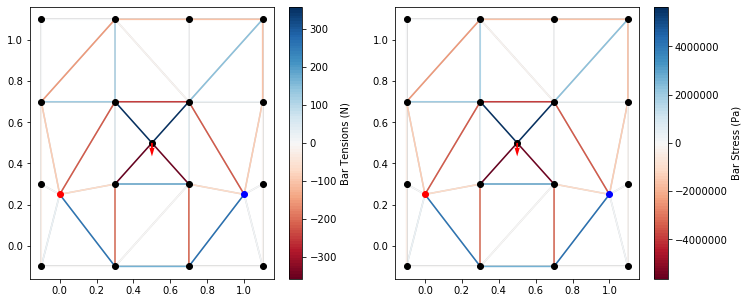

In [11]:
gridTruss.plot()

In [12]:
gridTruss.mass()

2.8597141390472562

In [13]:
gridTruss.details()

/Users/Devansh/Documents/GitHub/AVD_Initial_Sizing/Detailed_Design/truss.py:432: RuntimeWarning: divide by zero encountered in double_scalars
  bar_deets = [[i, b.node0, b.node1, b.E/10**9, b.yield_strength/10**6, b.w*1000, b.t*1000, b.area()*10**6, b.I()*10**12, b.length(), b.mass(), b.buckling_load(), b.tension(), b.extension()*1000, b.stress()/10**6, b.strain(), b.qBuckle(), b.qYield(), -min(b.buckling_load()/b.tension(), 0), b.yield_strength/b.stress()] for i, b in enumerate(self.bars)]


(    ID  x (m)  y (m)  Free x?  Free y?  Force x (N)  Force y (N)  \
 0    0   -0.1   1.10     True     True            0            0   
 1    1    0.3   1.10     True     True            0            0   
 2    2    0.7   1.10     True     True            0            0   
 3    3    0.3  -0.10     True     True            0            0   
 4    4   -0.1  -0.10     True     True            0            0   
 5    5    0.0   0.25    False    False            0            0   
 6    6   -0.1   0.30     True     True            0            0   
 7    7   -0.1   0.70     True     True            0            0   
 8    8    0.3   0.30     True     True            0            0   
 9    9    0.3   0.70     True     True            0            0   
 10  10    0.7  -0.10     True     True            0            0   
 11  11    0.7   0.30     True     True            0            0   
 12  12    0.7   0.70     True     True            0            0   
 13  13    1.1   0.70     True    

In [14]:
algo = nlopt.LD_MMA
n = len(gridTruss.bars)
opt = nlopt.opt(algo, n)

In [15]:
opt

<nlopt.opt; proxy of <Swig Object of type 'nlopt::opt *' at 0x117193750> >

In [16]:
def f(x, grad):
    if grad.size > 0:
        
        grad[:] = [bar.t * bar.stress()**2 * bar.length() / bar.E for bar in gridTruss.bars]
    
    gridTruss.set_widths(x)
    
    gridTruss.solve()
    
    return np.dot(gridTruss.F, gridTruss.u)


opt.set_min_objective(f)

In [17]:
opt.set_lower_bounds(0.1e-3)
opt.set_upper_bounds(100e-3)

In [18]:
opt.remove_equality_constraints()
opt.remove_inequality_constraints()

In [19]:
def mass_fc(x, grad):
    
    if grad.size > 0:
        
        grad[:] = [bar.t*bar.length()*bar.density for bar in gridTruss.bars]
    
    gridTruss.set_widths(x)
    
    return gridTruss.mass() - 3

opt.add_inequality_constraint(mass_fc)

In [20]:
def buckling_fc(x, grad):
    
    gridTruss.set_widths(x)
    gridTruss.solve()
    
    s = 0.0
    s += sum(- b.tension() for b in gridTruss.bars if b.tension() + b.buckling_load() < 0)
    
    return s

opt.add_inequality_constraint(buckling_fc)

In [21]:
def c(result, x, grad):
    
    gridTruss.set_widths(x)
    
    gridTruss.solve()
    
    result[:] = [- b.tension() - b.buckling_load() for b in gridTruss.bars]
    
    
#opt.add_inequality_mconstraint(c, np.zeros(n))
#opt.add_equality_constraint(h, tol=0)

In [22]:
#opt.set_xtol_rel(0.01e-3)
opt.set_maxtime(40)

In [23]:
x0 = np.array([20e-3 for b in gridTruss.bars])
xopt = opt.optimize(x0)

In [24]:
f(x0, np.ones(0)),mass_fc(x0, np.ones(0)) # when tmax = 60

(0.0444671708366963, 2.7194282780945125)

In [25]:
f(xopt, np.ones(0)),mass_fc(xopt, np.ones(0)) # when tmax = 60

(0.095970259012874, -0.39057776004646216)

In [26]:
f(xopt, np.ones(0)),mass_fc(xopt, np.ones(0)) # when tmax = 60

(0.095970259012874, -0.39057776004646216)

In [27]:
result = opt.last_optimize_result()
result

6

In [28]:
x0

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

In [29]:
xopt

array([0.00938761, 0.01002639, 0.00938761, 0.00938761, 0.00685914,
       0.00838519, 0.00938761, 0.01117919, 0.01002639, 0.0072016 ,
       0.01162002, 0.01162002, 0.00938761, 0.01162002, 0.01162002,
       0.00685914, 0.00938761, 0.00938761, 0.00685914, 0.00938761,
       0.00938761, 0.0159598 , 0.00838519, 0.00938761, 0.00938761,
       0.00938761, 0.01117919, 0.0072016 , 0.00938761, 0.00938761,
       0.0159598 , 0.00838519, 0.00838519, 0.00938761, 0.00938761,
       0.00938761, 0.00938761, 0.00938761, 0.00685914, 0.00938761,
       0.00938761, 0.00938761])

In [30]:
xopt

array([0.00938761, 0.01002639, 0.00938761, 0.00938761, 0.00685914,
       0.00838519, 0.00938761, 0.01117919, 0.01002639, 0.0072016 ,
       0.01162002, 0.01162002, 0.00938761, 0.01162002, 0.01162002,
       0.00685914, 0.00938761, 0.00938761, 0.00685914, 0.00938761,
       0.00938761, 0.0159598 , 0.00838519, 0.00938761, 0.00938761,
       0.00938761, 0.01117919, 0.0072016 , 0.00938761, 0.00938761,
       0.0159598 , 0.00838519, 0.00838519, 0.00938761, 0.00938761,
       0.00938761, 0.00938761, 0.00938761, 0.00685914, 0.00938761,
       0.00938761, 0.00938761])

In [31]:
min(xopt)*1e3, max(xopt)*1e3

(6.859139438668135, 15.959796572366548)

In [32]:
gridTruss.set_widths(xopt)
gridTruss.solve()
gridTruss.mass()

2.609422239953538

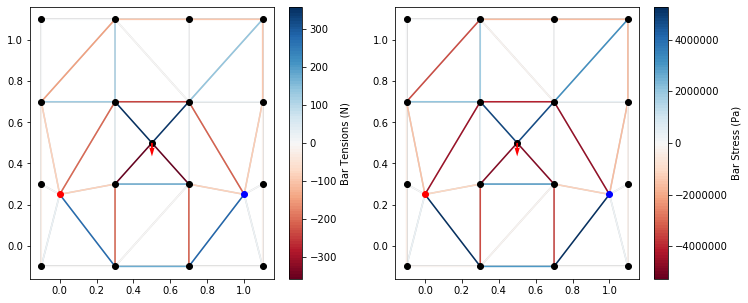

In [33]:
gridTruss.plot()

In [34]:
df_n, df_b = gridTruss.details()

In [35]:
df_n

,ID,x (m),y (m),Free x?,Free y?,Force x (N),Force y (N),Delta x (mm),Delta y (mm)
0,0,-0.1,1.10,True,True,0,0,0.014610,-0.007579
1,1,0.3,1.10,True,True,0,0,0.014610,-0.047349
2,2,0.7,1.10,True,True,0,0,0.005167,-0.058174
3,3,0.3,-0.10,True,True,0,0,0.004074,-0.041157
4,4,-0.1,-0.10,True,True,0,0,0.004685,-0.003307
5,5,0.0,0.25,False,False,0,0,0.000000,0.000000
6,6,-0.1,0.30,True,True,0,0,-0.002721,-0.005443
7,7,-0.1,0.70,True,True,0,0,0.013097,-0.007579
8,8,0.3,0.30,True,True,0,0,0.005254,-0.060743
9,9,0.3,0.70,True,True,0,0,0.024702,-0.057673


In [36]:
df_b

,ID,Node 0,Node 1,E (GPa),Yield (MPa),w (mm),t (mm),A (mm2),I (mm4),L (m),m (kg),Buckling Load (N),T (N),ext (mm),Stress (MPa),Strain,Will buckle?,Will yield?,Buckle Margin,Yield Margin
0,0,"N(0.30, 1.10)","N(0.70, 1.10)",71.0,300.0,9.387607,6.35,59.611301,200.306392,0.400000,0.064380,877.269274,-9.990996e+01,-9.442387e-03,-1.676024e+00,-2.360597e-05,False,False,8.780599e+00,-1.789951e+02
1,1,"N(1.00, 0.25)","N(1.10, -0.10)",71.0,300.0,10.026387,6.35,63.667558,213.936258,0.364005,0.062573,1131.427189,1.530227e+01,1.232217e-03,2.403464e-01,3.385160e-06,False,False,0.000000e+00,1.248199e+03
2,2,"N(1.10, -0.10)","N(1.10, 0.30)",71.0,300.0,9.387607,6.35,59.611301,200.306392,0.400000,0.064380,877.269274,-1.471349e+01,-1.390557e-03,-2.468239e-01,-3.476393e-06,False,False,5.962345e+01,-1.215441e+03
3,3,"N(0.30, 0.30)","N(0.70, 0.30)",71.0,300.0,9.387607,6.35,59.611301,200.306392,0.400000,0.064380,877.269274,1.742922e+02,1.647218e-02,2.923812e+00,4.118045e-05,False,False,0.000000e+00,1.026058e+02
4,4,"N(0.70, 0.70)","N(1.10, 1.10)",71.0,300.0,6.859139,6.35,43.555535,146.355673,0.565685,0.066525,320.492357,1.412940e+02,2.584622e-02,3.243997e+00,4.569010e-05,False,False,0.000000e+00,9.247851e+01
5,5,"N(1.00, 0.25)","N(0.70, -0.10)",71.0,300.0,8.385189,6.35,53.245947,178.917476,0.460977,0.066272,589.999879,2.804677e+02,3.419931e-02,5.267399e+00,7.418872e-05,False,False,0.000000e+00,5.695411e+01
6,6,"N(0.70, -0.10)","N(0.70, 0.30)",71.0,300.0,9.387607,6.35,59.611301,200.306392,0.400000,0.064380,877.269274,-2.129469e+02,-2.012539e-02,-3.572257e+00,-5.031349e-05,False,False,4.119662e+00,-8.398051e+01
7,7,"N(0.00, 0.25)","N(0.30, 0.30)",71.0,300.0,11.179187,6.35,70.987838,238.533926,0.304138,0.058293,1807.034804,-7.960329e+01,-4.803520e-03,-1.121365e+00,-1.579388e-05,False,False,2.270050e+01,-2.675311e+02
8,8,"N(0.00, 0.25)","N(-0.10, -0.10)",71.0,300.0,10.026387,6.35,63.667558,213.936258,0.364005,0.062573,1131.427189,2.350395e+01,1.892658e-03,3.691668e-01,5.199532e-06,False,False,0.000000e+00,8.126408e+02
9,9,"N(0.00, 0.25)","N(0.30, 0.70)",71.0,300.0,7.201604,6.35,45.730183,153.662943,0.540833,0.066777,368.130135,-2.058225e+02,-3.428425e-02,-4.500803e+00,-6.339159e-05,False,False,1.788580e+00,-6.665477e+01


In [37]:
df_b[['w (mm)', 'Buckling Load (N)', 'T (N)','Will buckle?']]

,w (mm),Buckling Load (N),T (N),Will buckle?
0,9.387607,877.269274,-9.990996e+01,False
1,10.026387,1131.427189,1.530227e+01,False
2,9.387607,877.269274,-1.471349e+01,False
3,9.387607,877.269274,1.742922e+02,False
4,6.859139,320.492357,1.412940e+02,False
5,8.385189,589.999879,2.804677e+02,False
6,9.387607,877.269274,-2.129469e+02,False
7,11.179187,1807.034804,-7.960329e+01,False
8,10.026387,1131.427189,2.350395e+01,False
9,7.201604,368.130135,-2.058225e+02,False


In [38]:
max(b.w for b in gridTruss.bars)

0.01595979657236655